In [50]:
import pandas as pd
import numpy as np
import plotnine as p9

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg 

from sklearn.linear_model import Lasso
import math
from itertools import combinations 
from sklearn import metrics

import shap

<h1>Extracting the daily community mobility number from Google data</h1>

1. The first step is converting the pdf files into high quality image files. We have converted the PDFs into bitmap (.bmp) files. 
2. Second step is identifying the pixels that correspons to the start of the x and y axis for each row and each column of the 12 graphs in onefile. Same x and y axis can be used for all the other files. Also find how much % change is represented by 1 pixel, how many pixels represent one day and where is the basesline. We need to do this step for just one graph and it can be translated to all the graphs.
3. Once we know where the graph lies in the PDF, use color to identify the end pixel (either above baseline or below baseline) to extract the exact value of % change. <b>This step depends on the file conversion software used as pixel colors might change depending on the software.</b> So check which colors represent the curve in the community mobility data.


<b>NOTE</b> Google recently released the csv file as well so dont need to do extraction from image.

<h3>Using the converted file</h3>

(3508, 2479, 3)


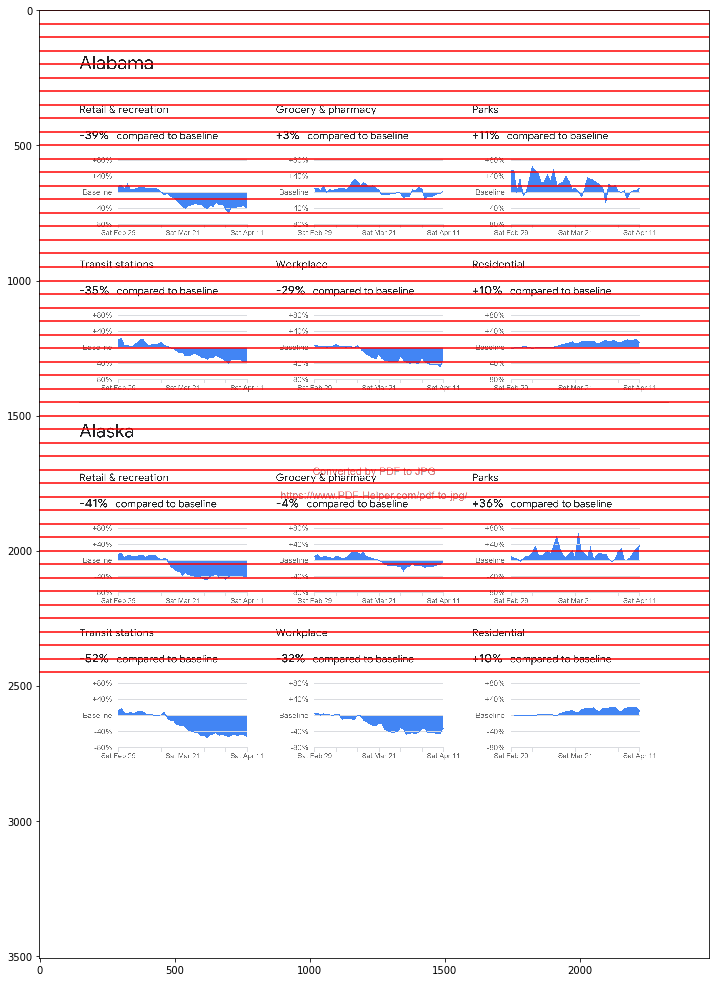

In [7]:
# assuming we have the .bmp files (uploaded in the repository), checking one of the files
# Read Images 
img = mpimg.imread('.//mobility//usa//mob-rep-en-200411-united_states3.bmp') 
  
# Output Images
fig = plt.figure(figsize = (12,38))
plt.imshow(img);

# the pdf is converted to numpy matrix with shape
print(img.shape)

# drawing horizontal and vertical lines to see the exact placement of the graph
for yr in range(50):
    plt.axhline(y=yr*50, color='r');

<h3>using the file above to find pixel values</h3>

In [8]:
# location of important points in the image file

X1 = [291,1017,1744]        # starting pixel of the graphs (3 columns) across x axis
X2 = [770,1496,2223]        # ending pixel of the graphs (3 columns) across x axis
Y1 = [500,1080,1870,2450]   # starting pixel of the graphs (4 rows) across y axis 
Y2 = [800,1380,2170,2750]   # ending pixel of the graphs (4 rows) across y axis 

baselineX = [673,1249,2035,2611]   
one_pixel = 40/60                  # percentage change (using the difference between 0 and 40 % lines)
totalDays = 43                     # numbre of days
pixel_day = 11.4                   # pixels that show the days across x axis

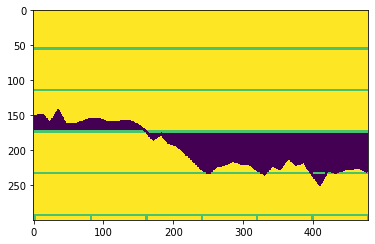

In [10]:
# example of a graph from the image file
# just using one of the color channels as this gives the minimum value to the pixels we need
# so for each day we can just find the location for where minimum pixel value lies and how far it is from baseline

temp = img[Y1[0]:Y2[0],X1[0]:X2[0],1]
plt.imshow(temp);

In [28]:
# finding the values for the change in cimmunity mobility

popularity_usa = np.zeros([51,43,6])  # 50 states+DC
count = 0
flag  = 0

for g in range(26):
    img = mpimg.imread('.//mobility//usa//mob-rep-en-200411-united_states'+str(g+3)+'.bmp') 

    for y in range(4):
        base = baselineX[y]-Y1[y]
        sind = int(count/6)
            
        for x in range(3):
            rind = count%6
            temp = img[Y1[y]:Y2[y],X1[x]:X2[x],1]

            for j in range(totalDays):
                c   = temp[:,int(pixel_day*j)]
                
                if c[np.argmin(c)] > 150:
                    diff = 0
                else: 
                    # looking for the pixel value less than 140
                    min_val = np.min(c)
                    min_indices = np.where(c<140)
                    
                    if np.min(min_indices) <= base:
                        ind = np.min(min_indices)
                    elif np.max(min_indices) >= base:
                        ind = np.max(min_indices)
                    else:
                        ind = base
                    
                    diff = (base-ind)*one_pixel

                popularity_usa[sind,j,rind] = diff
            count += 1
                
        if sind == 50:
            flag = 1
            break
            
    # this is for ending the file (26th page has just one state information)        
    if flag == 1:
        break
            

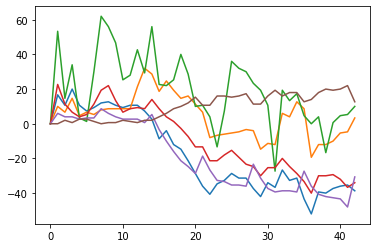

In [30]:
# checking the values for the Alabama (first state)
# check it if it aligns with the actual graph, it not, there might be some errors in pixel value selection
plt.plot(popularity_usa[0,:,:]);

<h3>Government Policies</h3>

All different states introduced non-pharmaceutical intervantions / policies to enforce social distancing. Different policies that were implemented on different dates by the states is in the 'policy.csv' file

In [31]:
mobility = np.mean(popularity_usa[:,:,[0,1,3,4,5]],axis=2)  # excluding the parks as few people visit parks
mobility.shape                                              # 51 states and 43 days

(51, 43)

In [32]:
policy = pd.read_csv("policy.csv")
policy.head(2)

,Location,Mass gathering,Initial business closure,Education facilities,Non-essential services,Stay at home,self quarantine travel
0,Alabama,109,109,109,118,125,1000
1,Alaska,114,107,106,118,118,118


In [33]:
# also use the demographics data
demo = pd.read_csv("demographics.csv")
demo.head(2)

,Location,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Total
0,Alabama,1128300,419500,554400.0,1192600,646800,811000,4752600
1,Alaska,191100,62200,93400.0,182800,94100,85500,709100


In [44]:
'''
policy data description:
1. nUmber represents the day on which it was implemented (day from dec 1 2019), so we start from 90, march 20 = 110
2. 1000 shows that it was not implemented in that state
'''
number_of_states = 51
number_of_days   = 43

X = []
Y = []

for j in range(number_of_states):
    for d in range(number_of_days):
        x = []
        for a in range(5):
            x.append(demo.iloc[d,1+a]/demo.iloc[d,7])   # proportion of the first 5 age groups
            
        for p in range(6):                             # adding the policy if yes or no
            x.append(int(policy.iloc[j,1+p]-90 <= d))
    
        for p in range(6):                             # adding the days after it being implemented
            if policy.iloc[j,1+p]-90 <= d:
                x.append(np.log(d-(policy.iloc[j,1+p]-90)+1))
            else:
                x.append(0)
        
        # finding the day of the week (tues, wed, thurs, fri, sat, sun)
        # 0 is saturday,
        
        ddd = [0,0,0,0,0,0]
        day_dict = {0:4,1:5,3:0,4:1,5:2,6:3}    # day and the corresponding index of the day of the week
        w = d%7
        
        if w in day_dict.keys():
            ddd[day_dict[w]] = 1
            
        for vv in range(6):
            x.append(ddd[vv])
        
        X.append(x)
        Y.append(mobility[j,d])

In [48]:
cols = ['age1','age2','age3','age4','age5','p1','p2','p3','p4','p5','p6',\
        'ap1','ap2','ap3','ap4','ap5','ap6','tue','wed','thur','fri','sat','sun']

x = pd.DataFrame(X,columns=cols)
y = pd.DataFrame(Y,columns=['y'])

arr = ['p1','p2','p3','p4','p5','p6']

# collecting all the combinations of the different policies

for j in range(2,10):
    r = list(combinations(arr, j))
    for rr in r:
        s = "-"
        s = s.join(rr)
        x[s] = 1
        for k in range(j):
            x[s] *= x[rr[k]]

# checking for the interaction effect between the age groups and the policy

for i in range(5):
    for j in range(6):
        x['age'+str(i+1)+'-p'+str(j+1)] = x['age'+str(i+1)]*x['p'+str(j+1)]
        
x.shape

(2193, 110)

<h3>Building the lasso linear regression</h3>

0.8964608953867321


Objective did not converge. You might want to increase the number of iterations. Duality gap: 23293.499232158043, tolerance: 47.69948897765618


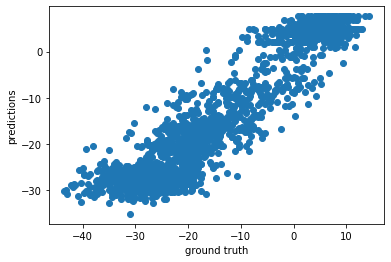

In [56]:
lasso = Lasso(alpha=0.0001)
lasso.fit(x,y)

y_pred = lasso.predict(x)
print(metrics.r2_score(y,y_pred))

plt.scatter(y,y_pred)
plt.xlabel("ground truth")
plt.ylabel("predictions");

<h3>Using Shap values to understand the effect of individual policies and demographics</h3>

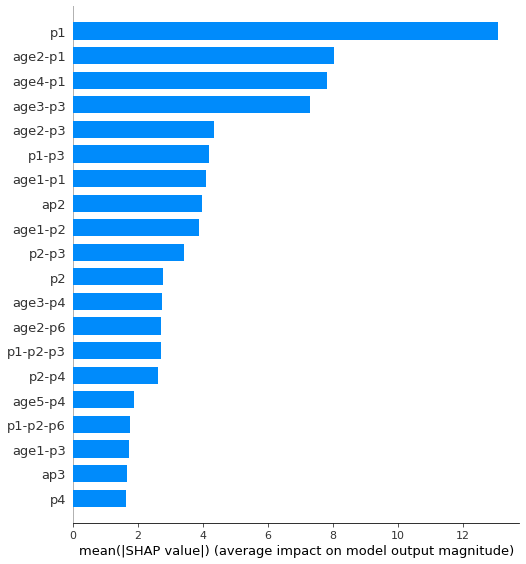

In [57]:
shap_values = shap.LinearExplainer(lasso,x).shap_values(x)
shap.summary_plot(shap_values, x, plot_type="bar")

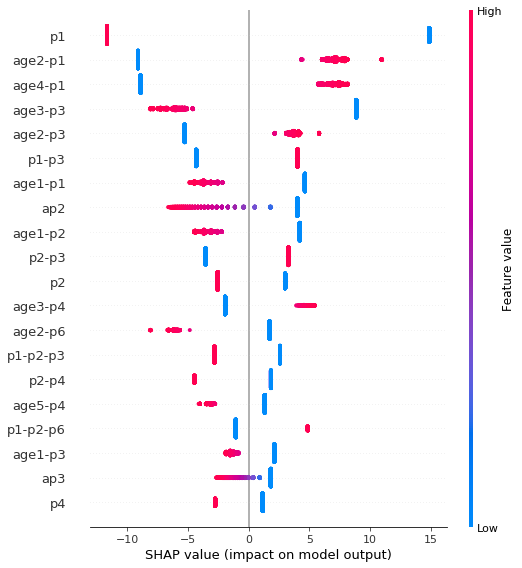

In [60]:
# the plot shows the contribution of different predictor variables for each individual data point
# absolute values of these individual contributions gives the graph above (similar to variable importance)

shap.summary_plot(shap_values, x)